# Task

> ### Finetune SAM model on Custom dataset to segment objects **without prompts**   (during training and inference)

# Approach

![https://github.com/yogendra-yatnalkar/SAM-Promptless-Task-Specific-Finetuning/blob/main/support-assets/SAM-promptless-task-specific-finetuning.png](https://raw.githubusercontent.com/yogendra-yatnalkar/SAM-Promptless-Task-Specific-Finetuning/main/support-assets/SAM-promptless-task-specific-finetuning.png)

---

### How does SAM work (high-level):
- Sam Encoder --> **ViT + Neck-Module** (Consisting of 2 Conv2D layers used for downsampling the channels of the ViT output)
- The Encoder ViT has a patch-size of **16x16**. 
- Input: **1024x1024x3**
- With the above patch-size and input-image-size, the **number patches formed are: 64x64**
- Output of Encoder: **256x64x64**
- This output goes into the decoder with **Prompt Input** and generates the output

---
### What I tried with code below: 
- Removed the decoder
- Freeze the ViT part of encoder and **un-freeze the Conv2d Neck**
- Add a custom decoder having multiple blocks of: **Conv2d-Transpose + LayerNorm2D + Relu + Dropout** --> ***Added 4 such blocks***
- The input to the decoder will be of shape: **256x64x64** and the output will be of shape: **1024x1024x1**

---
### Dataset Used: 

- https://www.kaggle.com/datasets/swagatajana/football-match-adboards-mask-dataset 

---
### Training: 
- I trained this SAM+Custom-Decoder model on a open kaggle dataset consisting of binary segmentation
- Dataset has **1620 images**. 
- **To prove SAM's capability, I trained this model only on 135 images, ie around 8.3% of the total data just for 11 epochs**

---
### Results: 
- **With a 91% IOU score on a completely random test-set**, the model's results are highly promising, suggesting its potential for real-world applications.
- **IMPORTANT NOTE:** When the same dataset (with same train-test split) was trained using **U2Net**, 
    - with **1346 image (83% of the entire dataset)**
    - and **75 epochs**, 
    - the **IOU score achieved was 91%**. 

- Check the result: ![https://github.com/yogendra-yatnalkar/SAM-Promptless-Task-Specific-Finetuning/](https://raw.githubusercontent.com/yogendra-yatnalkar/SAM-Promptless-Task-Specific-Finetuning/main/support-assets/result-sample.png)

- > **(Left-most image is the ground-truth, middle image is the model prediction, right-most image is the input)**


### Installing SAM dependencies and loading the model

In [2]:
!pwd
!ls /kaggle/input/football-match-adboards-mask-dataset

# Installing SAM and downloading model
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/kaggle/working
Masks  Tagged_Images
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-5zuh9yvi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-5zuh9yvi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-01-01 14:37:07--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.14, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth.1’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   346MB/s    in 1.0s    

2024-01-01 14:37:08 (346 MB/s) - ‘sam_vit_b_01ec64.pth.1’ 

In [3]:
import torch
from torch import nn
import numpy as np 
import os
from segment_anything import sam_model_registry
import glob
import torchvision
import matplotlib.pyplot as plt
import random

# setting global seed 
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# constants
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base_path = "/kaggle/input/football-match-adboards-mask-dataset/"
save_path = "/kaggle/working"
images_folder = "Tagged_Images/Tagged Images"
masks_folder = "Masks/Masks"
batch_size = 1
epochs = 11
t2_batch_size =1
train_split = 0.1

In [4]:
# Loadign the SAM model
sam = sam_model_registry["vit_b"](checkpoint="/kaggle/working/sam_vit_b_01ec64.pth")
# sam = sam_model_registry["vit_h"](checkpoint="/kaggle/working/sam_vit_h_4b8939.pth")

# moving the sam model to available device
sam = sam.to(device)

In [5]:
for layer_no, param in enumerate(sam.image_encoder.parameters()):
    pass
    
last_layer_no = layer_no
print("Last layer No: ", last_layer_no)

Last layer No:  176


In [6]:
# It seems that the last 6 layers of the model belong to CONV2d neck 
# used in the model to downsample the last attention layer embedding size
for layer_no, param in enumerate(sam.image_encoder.parameters()):
    if(layer_no > (last_layer_no - 6)):
        print(last_layer_no, param.shape)
    
last_layer_no = layer_no
print("Last layer No: ", last_layer_no)

176 torch.Size([256, 768, 1, 1])
176 torch.Size([256])
176 torch.Size([256])
176 torch.Size([256, 256, 3, 3])
176 torch.Size([256])
176 torch.Size([256])
Last layer No:  176


## Building the SAM decoder

In [7]:
# Layer Norm 2D code directly taken from the SAM Repository
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x

#### It is observed that the last 6 layers correspond to the Conv2D Neck

- Freeze the ViT
- UnFreeze the Conv2D neck 
- Add a Custom Decoder 

In [8]:
'''
The input of the SAM encoder is: 1024x1024x3
the output of the SAM encoder is: 256x64x64

Hence, having multuple conv2dTranspose to get an output shape of: 1x1024x1024
Note: The last layer of decoder is 1x1 layer such that: 16x1024x1024 -->  1x1024x1024
'''
class SAM_Decoder(nn.Module):
    def __init__(self, sam_encoder, sam_preprocess):
        super().__init__()
        self.sam_encoder = sam_encoder
        self.sam_preprocess = sam_preprocess
        for layer_no, param in enumerate(self.sam_encoder.parameters()):
            if(layer_no > (last_layer_no - 6)):
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        self.nn_drop = nn.Dropout(p = 0.2)
        
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2, padding = 0)
        self.norm1 = LayerNorm2d(128)
        
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 0)
        self.norm2 = LayerNorm2d(64)
        
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding = 0)
        self.norm3 = LayerNorm2d(32)
        
        self.conv4 = nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding = 0)
        self.norm4 = LayerNorm2d(16)
        
        self.conv5 = nn.ConvTranspose2d(16, 1, kernel_size = 1, stride = 1, padding = 0)
        
    def forward(self, x):
        x = self.sam_preprocess(x)
        x = self.sam_encoder(x)
            
        x = self.conv1(x)
        x = self.norm1(x)
        x = torch.nn.functional.relu(x)
        x = self.nn_drop(x)
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv3(x)
        x = self.norm3(x)
        x = torch.nn.functional.relu(x)
        x = self.nn_drop(x)
        
        x = self.conv4(x)
        x = self.norm4(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv5(x)
        x = torch.nn.functional.sigmoid(x)
        return x

In [9]:
sam_decoder = SAM_Decoder(sam_encoder = sam.image_encoder, sam_preprocess = sam.preprocess)
sam_decoder = sam_decoder.to(device)

In [10]:
def getNumParams(params):
    numParams, numTrainable = 0, 0
    for param in params:
        npParamCount = np.prod(param.data.shape)
        numParams += npParamCount
        if param.requires_grad:
            numTrainable += npParamCount
    return numParams, numTrainable

print("Number of parameters and number of trainable parameters: ", getNumParams(sam_decoder.parameters()))

Number of parameters and number of trainable parameters:  (89845729, 962273)


#### Total Number of Parameters: **89845729**
#### Total Number of Trainable-Parameters: **962273**

### Building the image data pipeline

In [11]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_path, image_folder, mask_folder, set_type = "train"):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.base_path = base_path
        self.device = device
        self.resize = torchvision.transforms.Resize(
            (1024, 1024), 
            interpolation=torchvision.transforms.InterpolationMode.NEAREST
        )

        
        self.all_img_files = glob.glob(os.path.join(self.base_path, self.image_folder, "**/*.jpg"),
                                       recursive=True)
        if set_type == "train":
            self.img_files = list(
                filter(lambda x: (int(x.split("frame")[-1].split(".")[0]) < 4000), self.all_img_files)
            
            )
        else:
            self.img_files = list(
                filter(lambda x: (int(x.split("frame")[-1].split(".")[0]) > 4000), self.all_img_files)
            )

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        image_path = self.img_files[index]
        
        # get the mask path
        mask_name = image_path.rsplit("/", 1)[-1].rsplit(".")[0] + ".png"
        mask_name = mask_name.replace("frame", "mask")
        mask_path = os.path.join(self.base_path, self.mask_folder, mask_name)
        
        # read both image and mask path
        image = torchvision.io.read_image(image_path)
        mask = torchvision.io.read_image(mask_path)
        
        # resizing the image and mask
        image = self.resize(image)
        mask = self.resize(mask)
        
        # chaging dtype of mask
        mask = mask.type(torch.float)
        image = image.type(torch.float)
        
        # standardizing the mask between 0 and 1
        mask = mask/255
    
        return image, mask

### 3 datasets: 

- The original dataset is devided into 3 different sub-sets. 
- This is because, an U2Net was trained earlier on the (training-set + T1 dataset) and T2 dataset was used as the Test/Evaluation Set. 
- **But the prove the capabilities of SAM, we will be training only on  a small sample for the original U2Net train set (which is currently the Train-set + T1 Test-set)**

In [27]:
# checking if dataset is ready to go
dataset = ImageDataset(base_path, images_folder, masks_folder, set_type = "train")

# split the dataset as train, test1 and test2 datasets
train_dataset, t1_dataset = torch.utils.data.random_split(dataset, [train_split, 1-train_split])

# The final test dataset
t2_dataset = ImageDataset(base_path, images_folder, masks_folder, set_type = "test")

# print the length of each set
print("Train set: ", len(train_dataset))
print("Test1 set: ", len(t1_dataset))
print("Test2 set: ", len(t2_dataset))

Train set:  135
Test1 set:  1211
Test2 set:  274


Temp Img shape, Temp Mask shape:  torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
image and mask, device and dtype:  torch.float32 cpu torch.float32 cpu


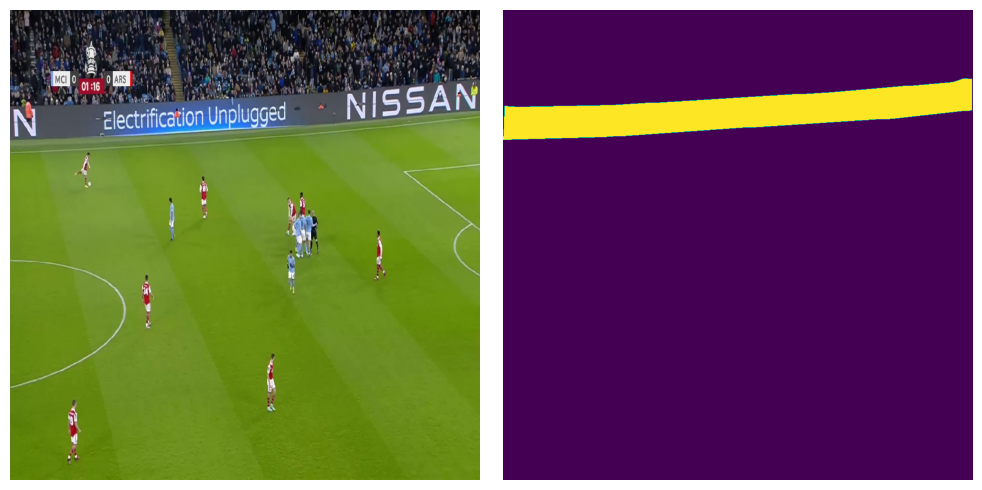

In [13]:
# taking the fist sample and plotting it 
temp_img, temp_mask = train_dataset[0]
print("Temp Img shape, Temp Mask shape: ", temp_img.shape, temp_mask.shape)
print("image and mask, device and dtype: ", temp_img.dtype, temp_img.device, 
      temp_mask.dtype, temp_mask.device)

temp_img_np = temp_img.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

temp_mask_np = temp_mask.to("cpu").numpy()
temp_mask_np = np.transpose(temp_mask_np, [1,2,0])

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(temp_img_np)
# Hide the axes of the first subplot
axs[0].axis('off')
# Display img2 on the second subplot
axs[1].imshow(temp_mask_np)
# Hide the axes of the second subplot
axs[1].axis('off')
# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

### DataLoader

In [14]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=5,
    prefetch_factor=3
)

t1_data_loader = torch.utils.data.DataLoader(
    t1_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=5,
    prefetch_factor=3
)

t2_data_loader = torch.utils.data.DataLoader(
    t2_dataset, 
    batch_size=t2_batch_size,
    shuffle=True,
    num_workers=5,
    prefetch_factor=3
)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
data_iter = iter(train_data_loader)
# Get the first batch
batch = next(data_iter)

print("Batch images and masks shape: ", batch[0].shape, batch[1].shape)
print("dtype and device: ", batch[0].dtype, batch[0].device)
print("dtype and device: ", batch[1].dtype, batch[1].device)

Batch images and masks shape:  torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1, 1024, 1024])
dtype and device:  torch.float32 cpu
dtype and device:  torch.float32 cpu


In [16]:
temp_decoder_output = sam_decoder(batch[0].to(device))
print(temp_decoder_output.shape)
print(torch.unique(temp_decoder_output))

torch.Size([1, 1, 1024, 1024])
tensor([0.0035, 0.0040, 0.0040,  ..., 0.9227, 0.9258, 0.9289], device='cuda:0',
       grad_fn=<Unique2Backward0>)


In [17]:
# total steps
total_steps = len(train_dataset)//batch_size
print("Total steps in each epoch: ", total_steps)

Total steps in each epoch:  135


## Training on the dataset 

- #### Only using 135 images

In [18]:
# Binary Cross Entropy Loss
bce_loss = torch.nn.BCELoss()

# Optimizer
optimizer = torch.optim.Adam(sam_decoder.parameters(), lr=0.01)

running_loss = 0.0
mini_batch_event = int(total_steps*0.25)
print("Mini_batch_event: ", mini_batch_event)

for epoch in range(epochs):
    sam_decoder.train()
    epoch_loss = 0
    mini_event_loss = 0
    
    for i, data in enumerate(train_data_loader, 0):
        images, masks = data
        
        # moving them to device
        images = images.to(device)
        masks = masks.to(device)
        
        # zero the parameter 
        optimizer.zero_grad()
        
        pred_masks = sam_decoder(images)
        loss = bce_loss(pred_masks, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        mini_event_loss += loss.item()
        if i % mini_batch_event == 0:    # print every nth mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {mini_event_loss / mini_batch_event:.3f}')
            mini_event_loss = 0
            
    print(f'=====> [{epoch + 1}, {i + 1:5d}] loss: {epoch_loss / total_steps:.3f}')
    
    if(i == 2):
        break

Mini_batch_event:  33
[1,     1] loss: 0.011
[1,    34] loss: 0.205
[1,    67] loss: 0.063
[1,   100] loss: 0.045
[1,   133] loss: 0.034
=====> [1,   135] loss: 0.088
[2,     1] loss: 0.001
[2,    34] loss: 0.028
[2,    67] loss: 0.032
[2,   100] loss: 0.029
[2,   133] loss: 0.028
=====> [2,   135] loss: 0.029
[3,     1] loss: 0.001
[3,    34] loss: 0.021
[3,    67] loss: 0.029
[3,   100] loss: 0.026
[3,   133] loss: 0.026
=====> [3,   135] loss: 0.025
[4,     1] loss: 0.000
[4,    34] loss: 0.025
[4,    67] loss: 0.017
[4,   100] loss: 0.020
[4,   133] loss: 0.027
=====> [4,   135] loss: 0.023
[5,     1] loss: 0.001
[5,    34] loss: 0.021
[5,    67] loss: 0.019
[5,   100] loss: 0.021
[5,   133] loss: 0.027
=====> [5,   135] loss: 0.022
[6,     1] loss: 0.001
[6,    34] loss: 0.023
[6,    67] loss: 0.017
[6,   100] loss: 0.026
[6,   133] loss: 0.020
=====> [6,   135] loss: 0.021
[7,     1] loss: 0.000
[7,    34] loss: 0.016
[7,    67] loss: 0.023
[7,   100] loss: 0.020
[7,   133] loss:

### Setting the model for inference/eval

In [19]:
sam_decoder.eval()
print("SAM model + Custom Decoder set to EVAL mode")

SAM model + Custom Decoder set to EVAL mode


### Plotting few outputs

torch.Size([1, 1, 1024, 1024])
Np arr shape:  (1024, 1024, 1) (1024, 1024, 1)


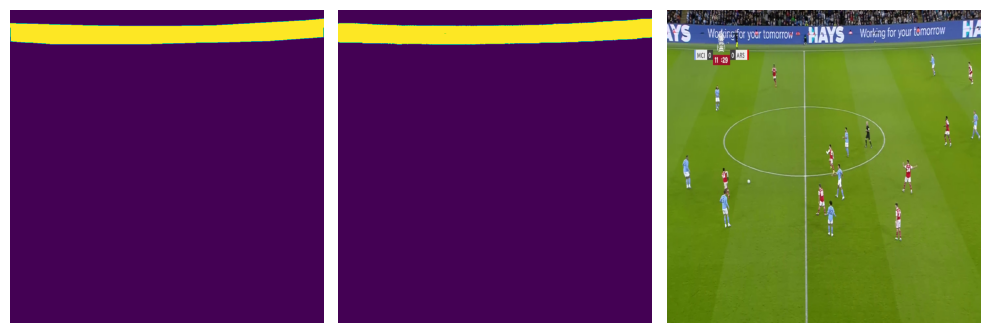

In [20]:
inpt_0, gt_0 = t1_dataset[0][0], t1_dataset[0][1]
with torch.no_grad():
    decoder_opt = sam_decoder(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

torch.Size([1, 1, 1024, 1024])
Np arr shape:  (1024, 1024, 1) (1024, 1024, 1)


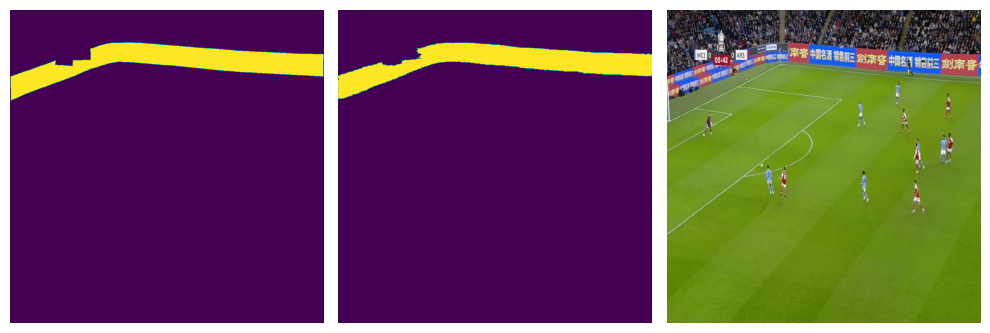

In [21]:
inpt_0, gt_0 = t1_dataset[-1][0], t1_dataset[-1][1]
with torch.no_grad():
    decoder_opt = sam_decoder(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

torch.Size([1, 1, 1024, 1024])
Np arr shape:  (1024, 1024, 1) (1024, 1024, 1)


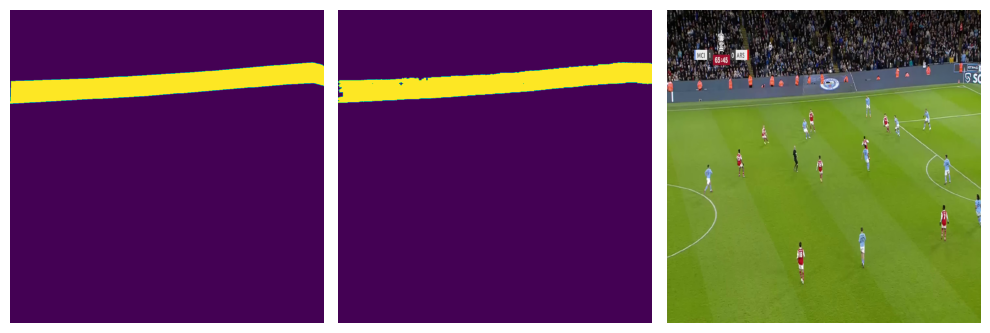

In [22]:
inpt_0, gt_0 = t2_dataset[0][0], t2_dataset[0][1]
with torch.no_grad():
    decoder_opt = sam_decoder(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

### T1 Dataset Loss

In [23]:
t1_total_steps = len(t1_dataset)//batch_size
print("T1 total steps: ", t1_total_steps)
with torch.no_grad():
    t1_loss = 0
    for i, test_data in enumerate(t1_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        test_inputs, test_labels = test_data

        # moving to device
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        pred_masks = sam_decoder(test_inputs)
        t1_step_loss = bce_loss(pred_masks, test_labels)
        
        t1_loss += t1_step_loss
        
print(f'-------------> Test T1 Loss: {t1_loss / t1_total_steps:.3f}')

T1 total steps:  1211
-------------> Test T1 Loss: 0.019


### T2 dataset loss

In [24]:
t2_total_steps = len(t2_dataset)//t2_batch_size
print("T1 total steps: ", t2_total_steps)
iou_loss_li = []

with torch.no_grad():
    t2_loss = 0
    for i, test_data in enumerate(t2_data_loader, 0):
        if(i%int(t2_total_steps*0.20) == 0):
            print(i)
        # get the inputs; data is a list of [inputs, labels]
        test_inputs, test_labels = test_data

        # moving to device
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        
        # Prediction
        pred_masks = sam_decoder(test_inputs)
        
        # BCE loss
        t2_step_loss = bce_loss(pred_masks, test_labels)
        t2_loss += t2_step_loss
        
        # IOU loss
        intersection = torch.logical_and((pred_masks > 0.5)*1.0, test_labels)
        union = torch.logical_or((pred_masks > 0.5)*1.0, test_labels)
        iou = torch.sum(intersection) / torch.sum(union)
        iou_loss_li.append(iou)
        
print(f'-------------> Test T1 Loss: {t2_loss / t2_total_steps:.3f}')
# print(f'-------------> Test T1 IOU Loss: {iou_loss_li}')
print("IOU LOSS: ", sum(iou_loss_li)/(len(iou_loss_li)))

T1 total steps:  274
0
54
108
162
216
270
-------------> Test T1 Loss: 0.017
IOU LOSS:  tensor(0.9103, device='cuda:0')


In [25]:
print(sum(iou_loss_li)/(len(iou_loss_li)))

tensor(0.9103, device='cuda:0')


## Saving the model

In [26]:
torch.save(sam_decoder.state_dict(), os.path.join(save_path, "sam_enc_custom_decoder.pt"))